**Chapter 15 – Recurrent Neural Networks**

_This notebook contains all the sample code in chapter 15._

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [8]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs

### Generate the Dataset

In [493]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [494]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [495]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


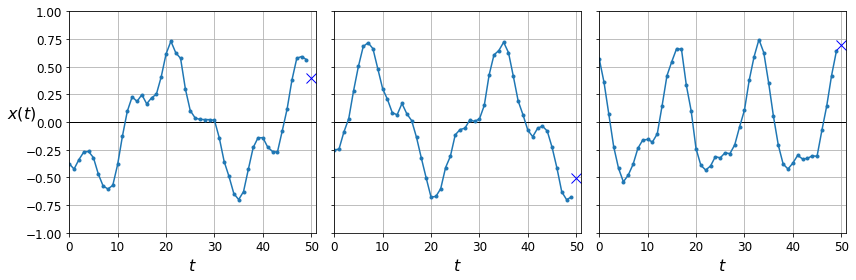

In [496]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [497]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

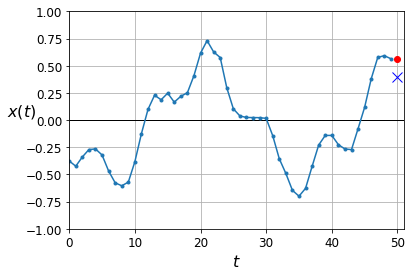

In [498]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [499]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 88us/sample - loss: 0.1015 - val_loss: 0.0551
Epoch 2/20
7000/7000 [==============================] - 0s 36us/sample - loss: 0.0384 - val_loss: 0.0267
Epoch 3/20
7000/7000 [==============================] - 0s 37us/sample - loss: 0.0205 - val_loss: 0.0161
Epoch 4/20
7000/7000 [==============================] - 0s 37us/sample - loss: 0.0133 - val_loss: 0.0119
Epoch 5/20
7000/7000 [==============================] - 0s 37us/sample - loss: 0.0104 - val_loss: 0.0099
Epoch 6/20
7000/7000 [==============================] - 0s 37us/sample - loss: 0.0090 - val_loss: 0.0088
Epoch 7/20
7000/7000 [==============================] - 0s 36us/sample - loss: 0.0081 - val_loss: 0.0079
Epoch 8/20
7000/7000 [==============================] - 0s 36us/sample - loss: 0.0073 - val_loss: 0.0074
Epoch 9/20
7000/7000 [==============================] - 0s 37us/sample - loss: 0.0067 - val_loss: 0.0066
Epoch 1

In [500]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 18us/sample - loss: 0.0042


0.00417404793202877

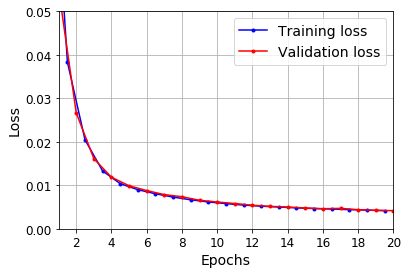

In [501]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

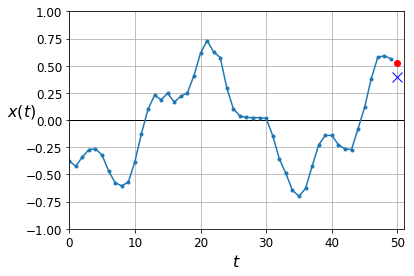

In [502]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [503]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(1)])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 685us/sample - loss: 0.2025 - val_loss: 0.1324
Epoch 2/20
7000/7000 [==============================] - 4s 583us/sample - loss: 0.1000 - val_loss: 0.0869
Epoch 3/20
7000/7000 [==============================] - 4s 574us/sample - loss: 0.0749 - val_loss: 0.0696
Epoch 4/20
7000/7000 [==============================] - 4s 574us/sample - loss: 0.0613 - val_loss: 0.0576
Epoch 5/20
7000/7000 [==============================] - 4s 586us/sample - loss: 0.0516 - val_loss: 0.0489
Epoch 6/20
7000/7000 [==============================] - 4s 585us/sample - loss: 0.0445 - val_loss: 0.0424
Epoch 7/20
7000/7000 [==============================] - 4s 591us/sample - loss: 0.0391 - val_loss: 0.0373
Epoch 8/20
7000/7000 [==============================] - 4s 560us/sample - loss: 0.0349 - val_loss: 0.0334
Epoch 9/20
7000/7000 [==============================] - 4s 597us/sample - loss: 0.0314 - val_loss: 0.030

In [504]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 156us/sample - loss: 0.0141


0.014110822692513465

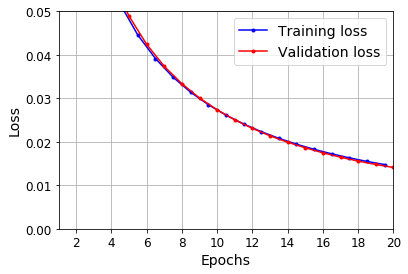

In [505]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

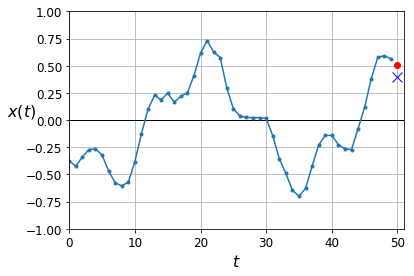

In [506]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [513]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0502 - val_loss: 0.0093
Epoch 2/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0069 - val_loss: 0.0055
Epoch 3/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0050 - val_loss: 0.0044
Epoch 4/20
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0048 - val_loss: 0.0040
Epoch 5/20
2816/7000 [===========>..................] - ETA: 6s - loss: 0.0042

KeyboardInterrupt: 

In [514]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 500us/sample - loss: 0.0038


0.003839029252529144

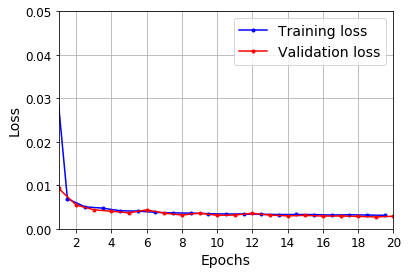

In [515]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

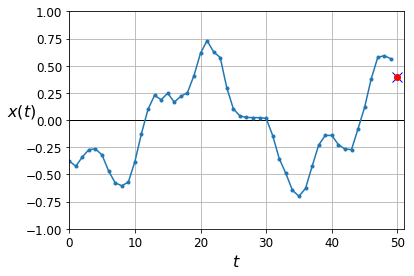

In [516]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_valid[0, 0])
plt.show()

In [517]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0212 - val_loss: 0.0053
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0041 - val_loss: 0.0034
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0034 - val_loss: 0.0031
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0033 - val_loss: 0.0030
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 7/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 10/20
7000

In [518]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 353us/sample - loss: 0.0027


0.0026770318262279032

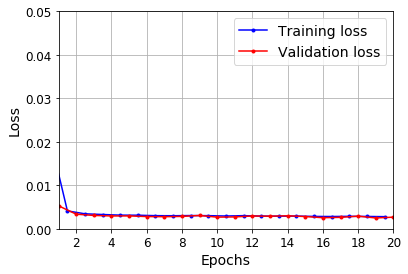

In [519]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

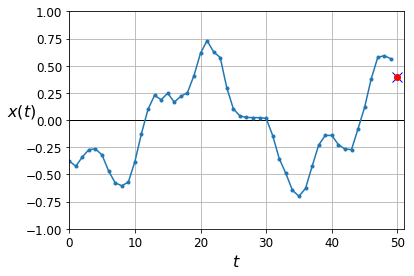

In [520]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_valid[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [390]:
X_new.shape

(1, 50, 1)

In [394]:
Y_pred.shape

(0, 10, 1)

In [401]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [402]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


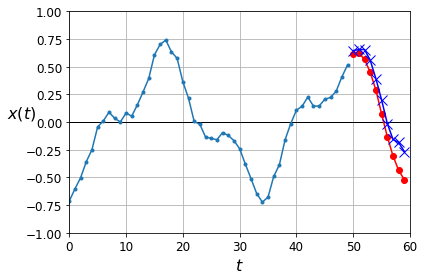

In [403]:
plot_series(X_new[0, :50, 0])
plt.plot(np.arange(50, 60), Y_pred[0, :, 0], "ro-")
plt.plot(np.arange(50, 60), Y_new[0, :, 0], "bx-", markersize=10)
plt.axis([0, 60, -1, 1])
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 10 next values at once:

In [521]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:]

In [522]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
    keras.layers.Lambda(lambda Y_pred: Y_pred[:, -10:])
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0633 - val_loss: 0.0380
Epoch 2/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0331 - val_loss: 0.0279
Epoch 3/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0264 - val_loss: 0.0256
Epoch 4/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0229 - val_loss: 0.0216
Epoch 5/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0219 - val_loss: 0.0213
Epoch 6/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0211 - val_loss: 0.0210
Epoch 7/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0210 - val_loss: 0.0194
Epoch 8/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0204 - val_loss: 0.0197
Epoch 9/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0201 - val_loss: 0.0197
Epoch 10/20
7000

In [523]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)

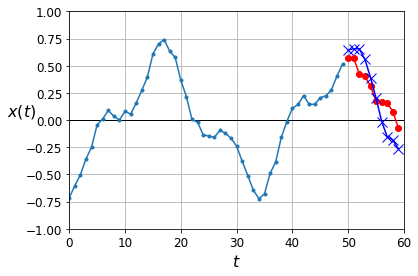

In [524]:
plot_series(X_new[0, :50, 0])
plt.plot(np.arange(50, 60), Y_pred[0, :, 0], "ro-")
plt.plot(np.arange(50, 60), Y_new[0, :, 0], "bx-", markersize=10)
plt.axis([0, 60, -1, 1])
plt.show()

Now let's create an RNN that predicts the input sequence, shifted 10 steps into the future:

In [531]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, 10:]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, 10:]
X_test, Y_test = series[9000:, :n_steps], series[9000:, 10:]

In [532]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 1))

In [527]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

def last_10_time_steps_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -10:], Y_pred[:, -10:])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0771 - last_10_time_steps_mse: 0.0677 - val_loss: 0.0576 - val_last_10_time_steps_mse: 0.0460
Epoch 2/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0552 - last_10_time_steps_mse: 0.0428 - val_loss: 0.0521 - val_last_10_time_steps_mse: 0.0385
Epoch 3/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0511 - last_10_time_steps_mse: 0.0367 - val_loss: 0.0516 - val_last_10_time_steps_mse: 0.0371
Epoch 4/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0480 - last_10_time_steps_mse: 0.0332 - val_loss: 0.0461 - val_last_10_time_steps_mse: 0.0308
Epoch 5/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0452 - last_10_time_steps_mse: 0.0300 - val_loss: 0.0437 - val_last_10_time_steps_mse: 0.0279
Epoch 6/20
7000/7000 [==============================] - 13s 2ms/sample - loss:

In [409]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -10:, :]

Saving figure forecast_ahead_multi_plot


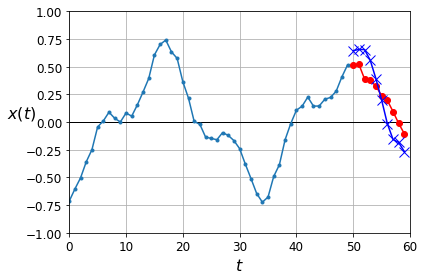

In [410]:
plot_series(X_new[0, :50, 0])
plt.plot(np.arange(50, 60), Y_pred[0, :, 0], "ro-")
plt.plot(np.arange(50, 60), Y_new[0, :, 0], "bx-", markersize=10)
plt.axis([0, 60, -1, 1])
save_fig("forecast_ahead_multi_plot")
plt.show()

# Deep RNN with Batch Norm

In [534]:
np.random.seed(42)
tf.random.set_seed(42)


model = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0834 - last_10_time_steps_mse: 0.0713 - val_loss: 0.0712 - val_last_10_time_steps_mse: 0.0674
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0537 - last_10_time_steps_mse: 0.0449 - val_loss: 0.0592 - val_last_10_time_steps_mse: 0.0531
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0508 - last_10_time_steps_mse: 0.0417 - val_loss: 0.0557 - val_last_10_time_steps_mse: 0.0487
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0481 - last_10_time_steps_mse: 0.0384 - val_loss: 0.0502 - val_last_10_time_steps_mse: 0.0409
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0456 - last_10_time_steps_mse: 0.0347 - val_loss: 0.0515 - val_last_10_time_steps_mse: 0.0409
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0

In [365]:
model.summary()

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch multiple                  4         
_________________________________________________________________
simple_rnn_132 (SimpleRNN)   multiple                  440       
_________________________________________________________________
batch_normalization_4 (Batch multiple                  80        
_________________________________________________________________
simple_rnn_133 (SimpleRNN)   multiple                  820       
_________________________________________________________________
batch_normalization_5 (Batch multiple                  80        
_________________________________________________________________
simple_rnn_134 (SimpleRNN)   multiple                  22        
Total params: 1,446
Trainable params: 1,364
Non-trainable params: 82
__________________________________________________

# Deep RNNs with Layer Norm

In [619]:
keras.layers.GRUCell.get_initial_state?

In [622]:
LayerNormalization = keras.layers.experimental.LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return tf.zeros([batch_size, self.state_size], dtype=dtype)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [623]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
4096/7000 [================>.............] - ETA: 7s - loss: 0.1483 - last_10_time_steps_mse: 0.1234

KeyboardInterrupt: 

# LSTMs

In [626]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
1120/7000 [===>..........................] - ETA: 16s - loss: 0.1102

KeyboardInterrupt: 

In [368]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 3s 1ms/sample - loss: 0.0039


0.003867200955748558

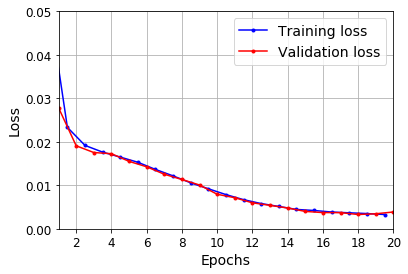

In [369]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

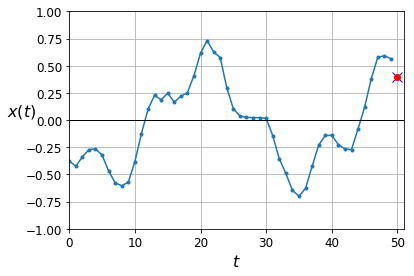

In [370]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_valid[0, 0])
plt.show()

# GRUs

In [648]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0805 - last_10_time_steps_mse: 0.0778 - val_loss: 0.0716 - val_last_10_time_steps_mse: 0.0673
Epoch 2/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0701 - last_10_time_steps_mse: 0.0655 - val_loss: 0.0684 - val_last_10_time_steps_mse: 0.0635
Epoch 3/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0648 - last_10_time_steps_mse: 0.0590 - val_loss: 0.0605 - val_last_10_time_steps_mse: 0.0522
Epoch 4/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0558 - last_10_time_steps_mse: 0.0448 - val_loss: 0.0515 - val_last_10_time_steps_mse: 0.0372
Epoch 5/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0489 - last_10_time_steps_mse: 0.0337 - val_loss: 0.0468 - val_last_10_time_steps_mse: 0.0297
Epoch 6/20
7000/7000 [==============================] - 17s 2ms/sample - loss

In [372]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 3s 2ms/sample - loss: 0.0030


0.002984777610749006

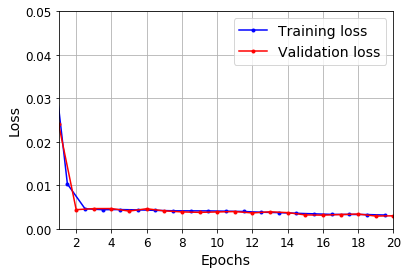

In [373]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

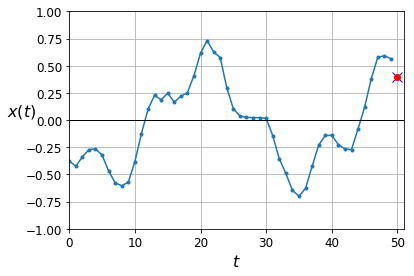

In [374]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_valid[0, 0])
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2----|      |-----5---...         |----23-----|
        |-----1----|      |-----4-----|   ...   |-----22----|
  |-----0----|      |-----3----|      |---...-21---|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59

Output:

X: 0  1  2  3  4  5  ... 19 20 21 22 23
Y: 13 15 17 19 21 23 ... 51 53 55 57 59
```

In [638]:
np.random.seed(42)
tf.random.set_seed(42)

def last_5_time_steps_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -5:], Y_pred[:, -5:])

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="VALID"),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_5_time_steps_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.0792 - last_5_time_steps_mse: 0.0762 - val_loss: 0.0696 - val_last_5_time_steps_mse: 0.0649
Epoch 2/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0638 - last_5_time_steps_mse: 0.0597 - val_loss: 0.0576 - val_last_5_time_steps_mse: 0.0533
Epoch 3/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0517 - last_5_time_steps_mse: 0.0453 - val_loss: 0.0474 - val_last_5_time_steps_mse: 0.0397
Epoch 4/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0463 - last_5_time_steps_mse: 0.0389 - val_loss: 0.0449 - val_last_5_time_steps_mse: 0.0368
Epoch 5/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0430 - last_5_time_steps_mse: 0.0350 - val_loss: 0.0414 - val_last_5_time_steps_mse: 0.0327
Epoch 6/20
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0400 - last

## WaveNet

```
C2     /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\ 
      /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59

Output:

X: 0  1  2  3  4  5  ... 19 20 21 22 23
Y: 13 15 17 19 21 23 ... 51 53 55 57 59
```

In [671]:
model = keras.models.Sequential()
for rate in (1, 2, 4, 8) * 2:
    activation = "relu" if len(model.layers) < 7 else None
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="VALID",
                                  activation=activation, dilation_rate=rate))

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train[:, 30:], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 30:]))


Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 484us/sample - loss: 0.0670 - last_10_time_steps_mse: 0.0667 - val_loss: 0.0372 - val_last_10_time_steps_mse: 0.0370
Epoch 2/20
7000/7000 [==============================] - 2s 243us/sample - loss: 0.0300 - last_10_time_steps_mse: 0.0301 - val_loss: 0.0263 - val_last_10_time_steps_mse: 0.0254
Epoch 3/20
7000/7000 [==============================] - 2s 230us/sample - loss: 0.0243 - last_10_time_steps_mse: 0.0245 - val_loss: 0.0225 - val_last_10_time_steps_mse: 0.0222
Epoch 4/20
7000/7000 [==============================] - 2s 229us/sample - loss: 0.0217 - last_10_time_steps_mse: 0.0217 - val_loss: 0.0201 - val_last_10_time_steps_mse: 0.0200
Epoch 5/20
7000/7000 [==============================] - 2s 235us/sample - loss: 0.0199 - last_10_time_steps_mse: 0.0198 - val_loss: 0.0188 - val_last_10_time_steps_mse: 0.0189
Epoch 6/20
7000/7000 [==============================] - 2s 234us/sample 

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [734]:
from tensorflow import keras

class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [735]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.backend.temporal_padding(inputs, (dilation_rate, 0))
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2,
                            dilation_rate=dilation_rate)(z)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [736]:
inputs = keras.layers.Input(shape=[10000, 1])
skip_to_last = []
n_filters = 128
z = keras.backend.temporal_padding(inputs, (1, 0))
z = keras.layers.Conv1D(n_filters, kernel_size=2, kernel_size=1)(z)
for dilation_rate in [2**i for i in range(10)] * 3:
    z, skip = wavenet_residual_block(z, 128, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(128, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(256, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [732]:
seq_length = 10000
n_layers_per_block = 10
n_blocks = 3
n_filters = 128
n_outputs = 256

inputs = keras.layers.Input(shape=[seq_length, 1])
skip_to_last = []
z = inputs
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

# Low-Level RNN API

In [611]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        try:
            self.initial_state = self.cell.get_initial_state()
        except AttributeError:
            self.initial_state = [tf.zeros(shape=[size], dtype=inputs.dtype)
                                  for size in self.cell.states_size]
    def call(self, inputs):
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack(), states
        else:
            return outputs, states

In [612]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_10_time_steps_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

AttributeError: 'LNSimpleRNNCell' object has no attribute 'get_initial_state'

In [28]:
batch_size = 32

X_batch = X_train[:batch_size]
y_batch = y_train[:batch_size]

In [30]:
n_neurons = 10
cell = keras.layers.SimpleRNNCell(n_neurons)

states = [tf.zeros((batch_size, n_neurons))]
for step in range(n_steps):
    output, states = cell(X_batch[:, step], states)

### Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [467]:
n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(y_batch.numpy())

____________________ Batch 0 
X_batch
[[ 2  3  4  5]
 [10 11 12 13]
 [ 4  5  6  7]]
===== 
Y_batch
[[ 3  4  5  6]
 [11 12 13 14]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 8  9 10 11]
 [ 6  7  8  9]
 [ 0  1  2  3]]
===== 
Y_batch
[[ 9 10 11 12]
 [ 7  8  9 10]
 [ 1  2  3  4]]


# Char-RNN

In [452]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [453]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [454]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [468]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [469]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [470]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [471]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [472]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text]))
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [473]:
n_steps = 100 + 1 # 100 input characters, 1 target
dataset = dataset.repeat().window(n_steps, shift=1, drop_remainder=True)

In [474]:
dataset = dataset.flat_map(lambda window: window.batch(n_steps))

In [475]:
dataset = dataset.shuffle(10000).map(lambda window: (window[:-1], window[1:]))

In [476]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [477]:
batch_size = 32
dataset = dataset.batch(batch_size).prefetch(1)

In [478]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


In [482]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(max_id, return_sequences=True, activation="softmax"),
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=20)

Epoch 1/20
   30/31370 [..............................] - ETA: 4:45:54 - loss: 3.2854

KeyboardInterrupt: 

In [490]:
m = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(3, return_sequences=True, activation="softmax"),
    #keras.layers.TimeDistributed(keras.layers.Dense(3, activation="softmax")),
])
m.predict(np.random.rand(1, 10, 20)).sum(axis=-1)

array([[0.5119721 , 0.5016997 , 0.5043864 , 0.49613214, 0.48934078,
        0.49399444, 0.4913659 , 0.48866373, 0.4878905 , 0.48718998]],
      dtype=float32)

In [222]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts))
    return tf.one_hot(X, max_id)

In [224]:
X_new = preprocess(["How are yo"])
y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts([y_pred])

['u']

In [146]:
model.layers[-1].weights[1].shape

TensorShape([100])

In [232]:
def next_char(texts, temperature=1):
    X_new = preprocess(texts)
    y_proba = model.predict(X_new)
    logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(logits, 1)
    return tokenizer.sequences_to_texts(char_id.numpy())

In [234]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char([text], temperature)[0]
    return text

In [238]:
print(complete_text("W", temperature=0.001))

Who the wind the with the with the with the with th


In [365]:
print(complete_text("W", temperature=0.5))

What of the shout the mean which steel the time to 


In [240]:
print(complete_text("W", temperature=1000))

Wjl,oldzwlu!s&ma?3vck'au,lmzqgyuiakdv'c,xxdcfra'!y!


# Handling Sequences of Different Sizes

Let's shorten each time series by chopping off a random number of time steps (from the start, so we don't need to change the targets):

In [51]:
def shorten_series(X):
    row_lengths = np.random.randint(10, n_steps + 1, size=len(X))
    X_values = np.concatenate([row[-length:] for row, length in zip(X, row_lengths)])
    return tf.RaggedTensor.from_row_lengths(X_values, row_lengths)

In [52]:
np.random.seed(42)

X_train_ragged = shorten_series(X_train)
X_valid_ragged = shorten_series(X_valid)
X_test_ragged = shorten_series(X_test)

In [57]:
X_train_ragged.shape

TensorShape([7000, None, 1])

The lengths of the first 10 series:

In [53]:
[len(series) for series in X_train_ragged[:10]]

[48, 38, 24, 17, 30, 48, 28, 32, 20, 20]

In [148]:
mask_value = 1000.
X_train_padded = X_train_ragged.to_tensor(default_value=mask_value)
X_valid_padded = X_valid_ragged.to_tensor(default_value=mask_value)
X_test_padded = X_test_ragged.to_tensor(default_value=mask_value)

In [149]:
masking_layer = keras.layers.Masking(mask_value)
series = np.array([[[1.], [2.], [mask_value], [mask_value]],
                   [[3.], [4.], [5.], [mask_value]]])
masking_layer(series)

<tf.Tensor: id=104044416, shape=(2, 4, 1), dtype=float64, numpy=
array([[[1.],
        [2.],
        [0.],
        [0.]],

       [[3.],
        [4.],
        [5.],
        [0.]]])>

In [134]:
masking_layer.compute_mask(series)

<tf.Tensor: id=104020093, shape=(2, 4), dtype=bool, numpy=
array([[ True,  True, False, False],
       [ True,  True,  True, False]])>

In [165]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Masking(mask_value, input_shape=[50, 1]),
    keras.layers.SimpleRNN(10, return_sequences=True),
    keras.layers.SimpleRNN(10, return_sequences=True),
    keras.layers.SimpleRNN(1, return_sequences=True),
])
model(X_train_padded[:1])

<tf.Tensor: id=104077084, shape=(1, 50, 1), dtype=float32, numpy=
array([[[-0.00068992],
        [-0.00200569],
        [-0.00361941],
        [-0.00526954],
        [-0.00687824],
        [-0.00850901],
        [-0.01016673],
        [-0.01166035],
        [-0.01272605],
        [-0.01294072],
        [-0.01201372],
        [-0.0098801 ],
        [-0.00662576],
        [-0.00265054],
        [ 0.00160605],
        [ 0.00585597],
        [ 0.01008973],
        [ 0.01436709],
        [ 0.01900724],
        [ 0.02407813],
        [ 0.02951853],
        [ 0.03506298],
        [ 0.0403483 ],
        [ 0.04494317],
        [ 0.04865657],
        [ 0.05155847],
        [ 0.05382836],
        [ 0.0557879 ],
        [ 0.05757094],
        [ 0.05896269],
        [ 0.0596477 ],
        [ 0.05911723],
        [ 0.05703   ],
        [ 0.05340039],
        [ 0.04850142],
        [ 0.0427837 ],
        [ 0.03672973],
        [ 0.03053256],
        [ 0.02408931],
        [ 0.01717455],
        [ 0.00

In [170]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Masking(mask_value, input_shape=[50, 1]),
    keras.layers.SimpleRNN(10, return_sequences=True),
    keras.layers.SimpleRNN(100),
])
model(X_train_padded[:1])

<tf.Tensor: id=104086841, shape=(1, 100), dtype=float32, numpy=
array([[-0.00750317, -0.03638493, -0.2424077 ,  0.29940003, -0.07055387,
         0.08998916,  0.0760837 ,  0.37614322,  0.05763464, -0.1588603 ,
        -0.19830383, -0.19467868,  0.04704513,  0.24343753, -0.24282528,
        -0.2946071 , -0.1828758 ,  0.49235138,  0.26802367,  0.08169778,
         0.1985315 , -0.46295494,  0.22253476, -0.12037585, -0.40126026,
        -0.04847579, -0.45405143,  0.3769246 ,  0.00578977,  0.05992427,
        -0.6785823 , -0.36745408,  0.02034429,  0.4638774 ,  0.5634439 ,
         0.3398945 ,  0.02395011, -0.63559425, -0.04319974,  0.13008839,
        -0.27999327, -0.2632861 , -0.47376516,  0.08665394,  0.67113864,
        -0.12007099,  0.37172496,  0.42676854,  0.20204662, -0.2575923 ,
         0.30822068, -0.30333394,  0.8128973 ,  0.21713986,  0.61591685,
        -0.34745032,  0.63077205, -0.04395744, -0.36705342,  0.34424514,
         0.06142979,  0.2896957 , -0.23971175,  0.32691988, 

In [114]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Masking(input_shape=[50, 1]),
    keras.layers.SimpleRNN(10, return_sequences=True),
    keras.layers.SimpleRNN(10, return_sequences=True),
    keras.layers.SimpleRNN(1, activation=None)
])

In [ ]:
optimizer = keras.optimizers.SGD(lr=1e-4, momentum=0.95, nesterov=True)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train_padded, tf.constant(y_train), epochs=20,
                    validation_data=(X_valid_padded, tf.constant(y_valid)))

# Sketch RNN

In [1]:
import tensorflow_datasets as tfds

In [9]:
datasets = tfds.load("quickdraw_sketch_rnn", as_supervised=True)

In [11]:
train_set = datasets["train"]
valid_set = datasets["validation"]
test_set = datasets["test"]

In [13]:
for X_batch, y_batch in train_set.take(2):
    print(X_batch.shape)

(20, 3)
(13, 3)


In [3]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons],dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons,n_neurons],dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [4]:
import numpy as np

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [5]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]


In [6]:
print(Y1_val)

[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


## Using `static_rnn()`

**Note**: `tf.contrib.rnn` was partially moved to the core API in TensorFlow 1.2. Most of the `*Cell` and `*Wrapper` classes are now available in `tf.nn.rnn_cell`, and the `tf.contrib.rnn.static_rnn()` function is available as `tf.nn.static_rnn()`.

In [7]:
n_inputs = 3
n_neurons = 5

In [8]:
reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, [X0, X1],
                                       dtype=tf.float32)
Y0, Y1 = output_seqs

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [9]:
init = tf.global_variables_initializer()

In [10]:
X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [11]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542541 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [12]:
Y1_val

array([[ 0.99998885, -0.99976057, -0.0667929 , -0.9999803 ,  0.99982214],
       [-0.6524943 , -0.51520866, -0.37968948, -0.5922594 , -0.08968379],
       [ 0.99862397, -0.99715203, -0.03308626, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307606 ,  0.79671973]],
      dtype=float32)

In [13]:
from tensorflow_graph_in_jupyter import show_graph

In [14]:
show_graph(tf.get_default_graph())

## Packing sequences

In [15]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [16]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.nn.static_rnn(basic_cell, X_seqs,
                                       dtype=tf.float32)
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

In [17]:
init = tf.global_variables_initializer()

In [18]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [19]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]]


In [20]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]
 [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]
 [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]
 [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]


## Using `dynamic_rnn()`

In [21]:
n_steps = 2
n_inputs = 3
n_neurons = 5

In [22]:
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [23]:
init = tf.global_variables_initializer()

In [24]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [25]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.999996    0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.85227895  0.5845349  -0.78780943]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624866   0.99817705  0.80142   ]]]


In [26]:
show_graph(tf.get_default_graph())

## Setting the sequence lengths

In [27]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

In [28]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

In [29]:
init = tf.global_variables_initializer()

In [30]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])

In [31]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [32]:
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.956726    0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [33]:
print(states_val)

[[-1.          0.956726    0.99831694  0.99970174  0.96518576]
 [-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]
 [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]


## Training a sequence classifier

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.

In [34]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead.

In [35]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [36]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [37]:
X_test = X_test.reshape((-1, n_steps, n_inputs))

In [38]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.9533333 Test accuracy: 0.9288
1 Last batch accuracy: 0.96 Test accuracy: 0.9471
2 Last batch accuracy: 0.96 Test accuracy: 0.95
3 Last batch accuracy: 0.96666664 Test accuracy: 0.9574
4 Last batch accuracy: 0.97333336 Test accuracy: 0.9663
5 Last batch accuracy: 0.9266667 Test accuracy: 0.9658
6 Last batch accuracy: 0.96666664 Test accuracy: 0.9657
7 Last batch accuracy: 0.96666664 Test accuracy: 0.9727
8 Last batch accuracy: 0.9866667 Test accuracy: 0.9711
9 Last batch accuracy: 0.98 Test accuracy: 0.9726
10 Last batch accuracy: 0.9866667 Test accuracy: 0.9707
11 Last batch accuracy: 0.97333336 Test accuracy: 0.9743
12 Last batch accuracy: 0.96 Test accuracy: 0.9754
13 Last batch accuracy: 0.9533333 Test accuracy: 0.9528
14 Last batch accuracy: 0.97333336 Test accuracy: 0.9793
15 Last batch accuracy: 0.9866667 Test accuracy: 0.9755
16 Last batch accuracy: 0.98 Test accuracy: 0.9683
17 Last batch accuracy: 0.98 Test accuracy: 0.9754
18 Last batch accuracy: 0.98

# Multi-layer RNN

In [39]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [40]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons,
                                      activation=tf.nn.relu)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [41]:
states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [42]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.94 Test accuracy: 0.938
1 Last batch accuracy: 0.93333334 Test accuracy: 0.9611
2 Last batch accuracy: 0.97333336 Test accuracy: 0.9666
3 Last batch accuracy: 0.9866667 Test accuracy: 0.9685
4 Last batch accuracy: 0.98 Test accuracy: 0.9721
5 Last batch accuracy: 0.96666664 Test accuracy: 0.9752
6 Last batch accuracy: 0.99333334 Test accuracy: 0.9787
7 Last batch accuracy: 0.97333336 Test accuracy: 0.978
8 Last batch accuracy: 0.99333334 Test accuracy: 0.9749
9 Last batch accuracy: 0.99333334 Test accuracy: 0.976


# Time series

In [43]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Saving figure time_series_plot


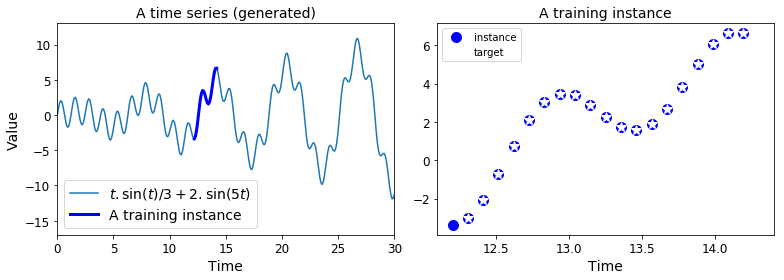

In [44]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


save_fig("time_series_plot")
plt.show()

In [45]:
X_batch, y_batch = next_batch(1, n_steps)

In [46]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

## Using an `OuputProjectionWrapper`

Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each traiing instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a sigle value:

In [47]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

In [48]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [50]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [51]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [52]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [53]:
saver = tf.train.Saver()

In [54]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") # not shown in the book

0 	MSE: 11.967254
100 	MSE: 0.525841
200 	MSE: 0.1495599
300 	MSE: 0.07279411
400 	MSE: 0.06158535
500 	MSE: 0.05938873
600 	MSE: 0.05470166
700 	MSE: 0.047849063
800 	MSE: 0.05107608
900 	MSE: 0.047209196
1000 	MSE: 0.047058314
1100 	MSE: 0.047831465
1200 	MSE: 0.04083041
1300 	MSE: 0.047086805
1400 	MSE: 0.041784383


In [55]:
with tf.Session() as sess:                          # not shown in the book
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [56]:
y_pred

array([[[-3.407753 ],
        [-2.4575484],
        [-1.1029298],
        [ 0.7815629],
        [ 2.2002175],
        [ 3.126768 ],
        [ 3.4037762],
        [ 3.3489153],
        [ 2.8798013],
        [ 2.2659323],
        [ 1.6447463],
        [ 1.5210768],
        [ 1.8972012],
        [ 2.7159088],
        [ 3.8894904],
        [ 5.140914 ],
        [ 6.142068 ],
        [ 6.666671 ],
        [ 6.6410103],
        [ 6.0725527]]], dtype=float32)

Saving figure time_series_pred_plot


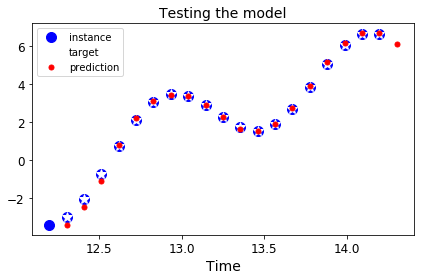

In [57]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

save_fig("time_series_pred_plot")
plt.show()

## Without using an `OutputProjectionWrapper`

In [58]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [59]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [60]:
n_outputs = 1
learning_rate = 0.001

In [61]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [62]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [63]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 13.907029
100 	MSE: 0.5056698
200 	MSE: 0.19735886
300 	MSE: 0.101214476
400 	MSE: 0.06850145
500 	MSE: 0.06291986
600 	MSE: 0.055129297
700 	MSE: 0.049436502
800 	MSE: 0.050434686
900 	MSE: 0.0482007
1000 	MSE: 0.04809868
1100 	MSE: 0.04982501
1200 	MSE: 0.041912545
1300 	MSE: 0.049292978
1400 	MSE: 0.043140374


In [64]:
y_pred

array([[[-3.4332483],
        [-2.4594698],
        [-1.1081185],
        [ 0.6882153],
        [ 2.1105688],
        [ 3.0585155],
        [ 3.5144088],
        [ 3.3531117],
        [ 2.808016 ],
        [ 2.1606152],
        [ 1.662645 ],
        [ 1.5578941],
        [ 1.9173537],
        [ 2.7210245],
        [ 3.8667865],
        [ 5.100083 ],
        [ 6.099999 ],
        [ 6.6480975],
        [ 6.6147423],
        [ 6.022089 ]]], dtype=float32)

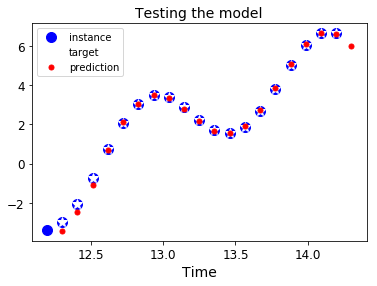

In [65]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

In [66]:
with tf.Session() as sess:                        # not shown in the book
    saver.restore(sess, "./my_time_series_model") # not shown

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


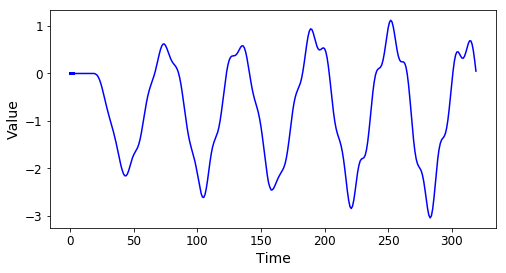

In [67]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model
Saving figure creative_sequence_plot


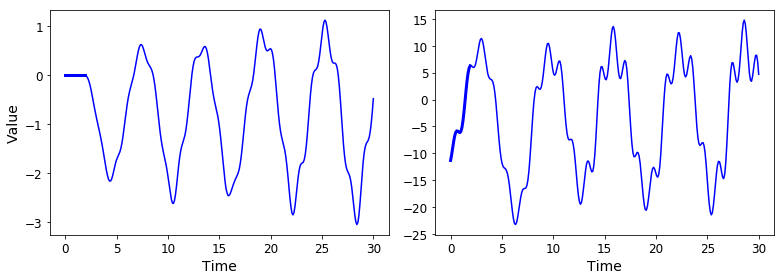

In [68]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
save_fig("creative_sequence_plot")
plt.show()

# Deep RNN

## MultiRNNCell

In [69]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [70]:
n_neurons = 100
n_layers = 3

layers = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [71]:
init = tf.global_variables_initializer()

In [72]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [73]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [74]:
outputs_val.shape

(2, 5, 100)

## Distributing a Deep RNN Across Multiple GPUs

Do **NOT** do this:

In [75]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)

Instead, you need a `DeviceCellWrapper`:

In [76]:
import tensorflow as tf

class DeviceCellWrapper(tf.nn.rnn_cell.RNNCell):
  def __init__(self, device, cell):
    self._cell = cell
    self._device = device

  @property
  def state_size(self):
    return self._cell.state_size

  @property
  def output_size(self):
    return self._cell.output_size

  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
        return self._cell(inputs, state, scope)

In [77]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [78]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Alternatively, since TensorFlow 1.1, you can use the `tf.contrib.rnn.DeviceWrapper` class (alias `tf.nn.rnn_cell.DeviceWrapper` since TF 1.2).

In [79]:
init = tf.global_variables_initializer()

In [80]:
with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[-3.29020061e-02  1.17019236e-01 -4.58992608e-02 ...  3.84477153e-02
   -5.24900258e-02  5.80436960e-02]
  [ 3.54288332e-02 -7.42610693e-02 -6.42375052e-02 ... -2.45757148e-01
   -1.77626804e-01 -3.26535292e-03]
  [ 2.59726584e-01  1.44605249e-01  3.29312116e-01 ...  3.38821977e-01
    5.98853417e-02 -8.31450596e-02]
  ...
  [ 1.18043743e-01 -2.41663873e-01 -8.27798247e-01 ... -1.85782462e-01
    1.89682379e-01 -1.35261893e-01]
  [ 2.87830859e-01  3.92953992e-01 -3.15236300e-01 ... -7.85605535e-02
    4.32724983e-01 -6.61824420e-02]
  [ 7.49779761e-01  6.11052871e-01 -3.01685542e-01 ...  1.95649698e-01
   -1.62457466e-01 -5.23968339e-02]]

 [[-6.68027624e-02  7.35576972e-02 -2.90275402e-02 ... -7.79968277e-02
   -3.65773253e-02 -4.66752201e-02]
  [ 1.71546549e-01  4.28418722e-03  2.18812120e-03 ...  3.68538052e-02
   -8.13241452e-02  9.01001915e-02]
  [ 3.45635489e-02 -9.57525298e-02  1.59450233e-01 ...  1.63022086e-01
   -6.83046281e-02  1.07990295e-01]
  ...
  [ 1.96414590e-01 -2.1

## Dropout

In [81]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

In [82]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

Note: the `input_keep_prob` parameter can be a placeholder, making it possible to set it to any value you want during training, and to 1.0 during testing (effectively turning dropout off). This is a much more elegant solution than what was recommended in earlier versions of the book (i.e., writing your own wrapper class or having a separate model for training and testing). Thanks to Shen Cheng for bringing this to my attention.

In [83]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [84]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [85]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:                   # not shown in the book
            print(iteration, "Training MSE:", mse) # not shown
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 16.386942
100 Training MSE: 5.836141
200 Training MSE: 3.5285974
300 Training MSE: 3.9488692
400 Training MSE: 2.2483113
500 Training MSE: 4.5033474
600 Training MSE: 3.4265506
700 Training MSE: 3.4990664
800 Training MSE: 3.7004602
900 Training MSE: 4.14042
1000 Training MSE: 3.5249038
1100 Training MSE: 3.3191948
1200 Training MSE: 2.9469335
1300 Training MSE: 3.2158706
1400 Training MSE: 4.4238644


In [86]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


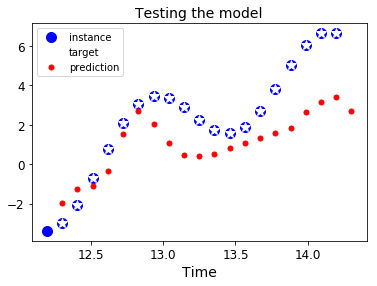

In [87]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Oops, it seems that Dropout does not help at all in this particular case. :/

# LSTM

In [88]:
reset_graph()

lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [89]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]
logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [90]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [91]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [92]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

0 Last batch accuracy: 0.96666664 Test accuracy: 0.9563
1 Last batch accuracy: 0.9533333 Test accuracy: 0.9652
2 Last batch accuracy: 0.96 Test accuracy: 0.9584
3 Last batch accuracy: 0.9866667 Test accuracy: 0.9769
4 Last batch accuracy: 0.98 Test accuracy: 0.9836
5 Last batch accuracy: 0.9866667 Test accuracy: 0.9843
6 Last batch accuracy: 0.99333334 Test accuracy: 0.9869
7 Last batch accuracy: 0.9866667 Test accuracy: 0.9857
8 Last batch accuracy: 0.99333334 Test accuracy: 0.9878
9 Last batch accuracy: 1.0 Test accuracy: 0.9871


In [93]:
lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, use_peepholes=True)

In [94]:
gru_cell = tf.nn.rnn_cell.GRUCell(num_units=n_neurons)

# Embeddings

This section is based on TensorFlow's [Word2Vec tutorial](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec/index.html).

## Fetch the data

In [95]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [96]:
words = fetch_words_data()

In [97]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

## Build the dictionary

In [98]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [99]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [100]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [101]:
words[24], data[24]

('culottes', 0)

## Generate batches

In [102]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [103]:
np.random.seed(42)

In [104]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [105]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [106]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

## Build the model

In [107]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [108]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [109]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [110]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [111]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

## Train the model

In [112]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  289.90948486328125
Nearest to over: tt, tuned, manichaeans, fractional, cambridge, balaguer, fluoride, strenuously,
Nearest to one: imagines, tijuana, hindrance, motorcyclist, steadfastly, lords, letting, hutchinson,
Nearest to were: bezier, antibodies, nicknamed, panthers, compiler, tao, smarter, busy,
Nearest to may: failure, rna, efficacious, aspirin, lecompton, definitive, geese, amphibious,
Nearest to two: annihilate, bettors, wir, cindy, epinephrine, team, voluntarily, crystallize,
Nearest to its: knob, abeokuta, bracelet, bastards, ivens, objectivity, blanton, cold,
Nearest to than: lame, watts, stones, sram, elves, zarqawi, applets, cloves,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to they: lowly, deportation, shrewd, reznor, tojo, decadent, occured, risotto,
Nearest to is: interests, golfers, dropouts, egyptians, richards, legionnaires, opener, leonel,
Nearest to up: clair, drives, steadfas

Let's save the final embeddings (of course you can use a TensorFlow `Saver` if you prefer):

In [113]:
np.save("./my_final_embeddings.npy", final_embeddings)

## Plot the embeddings

In [114]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

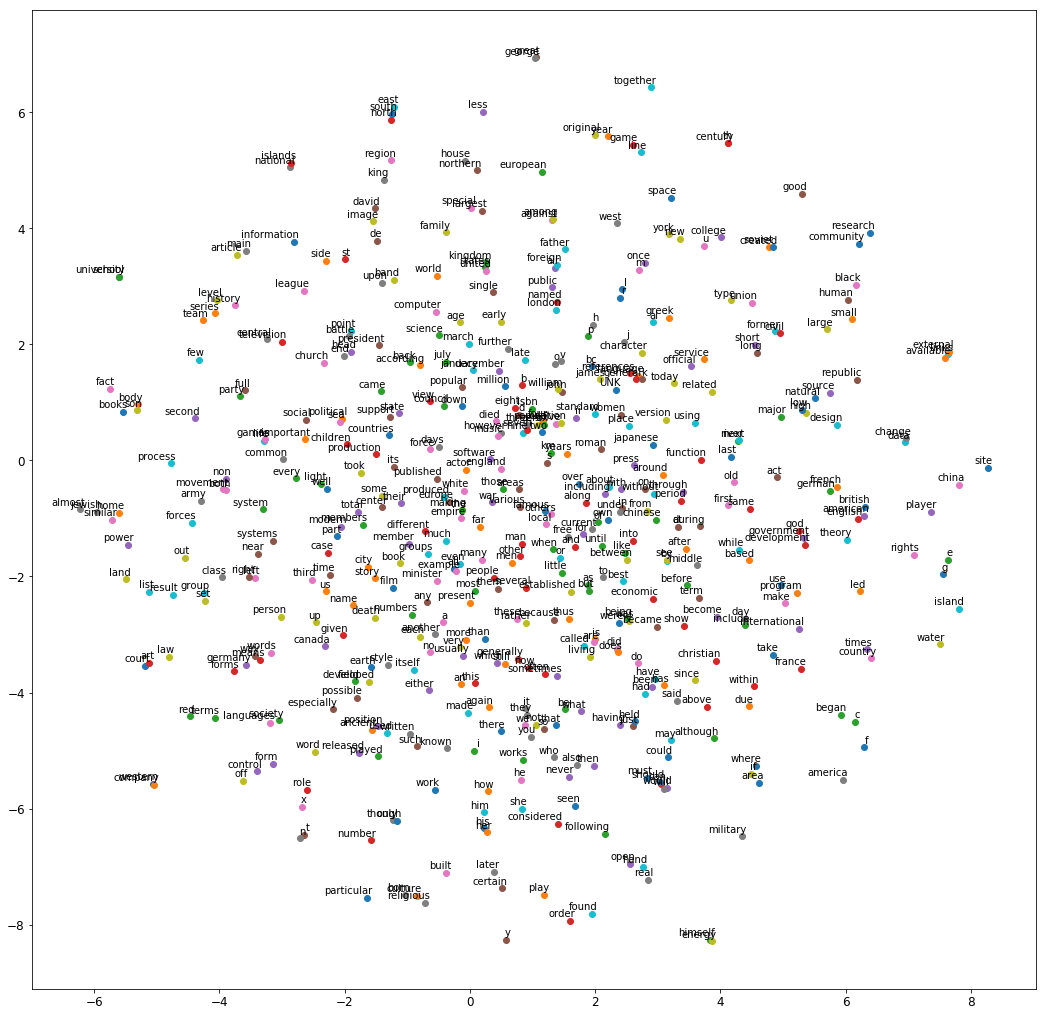

In [115]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Machine Translation

The `basic_rnn_seq2seq()` function creates a simple Encoder/Decoder model: it first runs an RNN to encode `encoder_inputs` into a state vector, then runs a decoder initialized with the last encoder state on `decoder_inputs`. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [116]:
import tensorflow as tf
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.nn.rnn_cell.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [117]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

# Exercise solutions

## 1. to 6.

See Appendix A.

## 7. Embedded Reber Grammars

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [118]:
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [119]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [120]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE BPBTSSSSSXXTTVPXVPXTTTVVEPE BPBTSSXXTVPSEPE BPBPTTTTTTTVPSEPE BTBTSXSETE BPBPTVPXVVEPE BPBPVVEPE BPBPTVVEPE BTBPTTVPXTTVPSETE BTBTSSXSETE BTBTXXTTVVETE BPBTSXSEPE BPBPTVPSEPE BTBPVVETE BPBTXXTTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [121]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [122]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTTTXXVVETE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS 

It's not possible to feed a string directly to an RNN: we need to convert it to a sequence of vectors, first. Each vector will represent a single letter, using a one-hot encoding. For example, the letter "B" will be represented as the vector `[1, 0, 0, 0, 0, 0, 0]`, the letter E will be represented as `[0, 1, 0, 0, 0, 0, 0]` and so on. Let's write a function that converts a string to a sequence of such one-hot vectors. Note that if the string is shorted than `n_steps`, it will be padded with zero vectors (later, we will tell TensorFlow how long each string actually is using the `sequence_length` parameter).

In [123]:
def string_to_one_hot_vectors(string, n_steps, chars="BEPSTVX"):
    char_to_index = {char: index for index, char in enumerate(chars)}
    output = np.zeros((n_steps, len(chars)), dtype=np.int32)
    for index, char in enumerate(string):
        output[index, char_to_index[char]] = 1.
    return output

In [124]:
string_to_one_hot_vectors("BTBTXSETE", 12)

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=int32)

We can now generate the dataset, with 50% good strings, and 50% bad strings:

In [125]:
def generate_dataset(size):
    good_strings = [generate_string(embedded_reber_grammar)
                    for _ in range(size // 2)]
    bad_strings = [generate_corrupted_string(embedded_reber_grammar)
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    n_steps = max([len(string) for string in all_strings])
    X = np.array([string_to_one_hot_vectors(string, n_steps)
                  for string in all_strings])
    seq_length = np.array([len(string) for string in all_strings])
    y = np.array([[1] for _ in range(len(good_strings))] +
                 [[0] for _ in range(len(bad_strings))])
    rnd_idx = np.random.permutation(size)
    return X[rnd_idx], seq_length[rnd_idx], y[rnd_idx]

In [126]:
X_train, l_train, y_train = generate_dataset(10000)

Let's take a look at the first training instances:

In [127]:
X_train[0]

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0,

It's padded with a lot of zeros because the longest string in the dataset is that long. How long is this particular string?

In [128]:
l_train[0]

23

What class is it?

In [129]:
y_train[0]

array([0])

Perfect! We are ready to create the RNN to identify good strings. We build a sequence classifier very similar to the one we built earlier to classify MNIST images, with two main differences:
* First, the input strings have variable length, so we need to specify the `sequence_length` when calling the `dynamic_rnn()` function.
* Second, this is a binary classifier, so we only need one output neuron that will output, for each input string, the estimated log probability that it is a good string. For multiclass classification, we used `sparse_softmax_cross_entropy_with_logits()` but for binary classification we use `sigmoid_cross_entropy_with_logits()`.


In [130]:
reset_graph()

possible_chars = "BEPSTVX"
n_inputs = len(possible_chars)
n_neurons = 30
n_outputs = 1

learning_rate = 0.02
momentum = 0.95

X = tf.placeholder(tf.float32, [None, None, n_inputs], name="X")
seq_length = tf.placeholder(tf.int32, [None], name="seq_length")
y = tf.placeholder(tf.float32, [None, 1], name="y")

gru_cell = tf.nn.rnn_cell.GRUCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(gru_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)

logits = tf.layers.dense(states, n_outputs, name="logits")
y_pred = tf.cast(tf.greater(logits, 0.), tf.float32, name="y_pred")
y_proba = tf.nn.sigmoid(logits, name="y_proba")

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=momentum,
                                       use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.equal(y_pred, y, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's generate a validation set so we can track progress during training:

In [131]:
X_val, l_val, y_val = generate_dataset(5000)

In [132]:
n_epochs = 50
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        X_batches = np.array_split(X_train, len(X_train) // batch_size)
        l_batches = np.array_split(l_train, len(l_train) // batch_size)
        y_batches = np.array_split(y_train, len(y_train) // batch_size)
        for X_batch, l_batch, y_batch in zip(X_batches, l_batches, y_batches):
            loss_val, _ = sess.run(
                [loss, training_op],
                feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, seq_length: l_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_val, seq_length: l_val, y: y_val})
        print("{:4d}  Train loss: {:.4f}, accuracy: {:.2f}%  Validation accuracy: {:.2f}%".format(
            epoch, loss_val, 100 * acc_train, 100 * acc_val))
        saver.save(sess, "./my_reber_classifier")

   0  Train loss: 0.6727, accuracy: 66.00%  Validation accuracy: 59.34%
   1  Train loss: 0.6553, accuracy: 68.00%  Validation accuracy: 61.82%
   2  Train loss: 0.6200, accuracy: 76.00%  Validation accuracy: 72.50%
   3  Train loss: 0.4908, accuracy: 82.00%  Validation accuracy: 73.22%
   4  Train loss: 0.4798, accuracy: 84.00%  Validation accuracy: 80.02%
   5  Train loss: 0.6061, accuracy: 74.00%  Validation accuracy: 72.68%
   6  Train loss: 0.5447, accuracy: 78.00%  Validation accuracy: 74.30%
   7  Train loss: 0.3604, accuracy: 88.00%  Validation accuracy: 86.40%
   8  Train loss: 0.3276, accuracy: 86.00%  Validation accuracy: 87.50%
   9  Train loss: 0.1783, accuracy: 96.00%  Validation accuracy: 94.18%
  10  Train loss: 0.1361, accuracy: 98.00%  Validation accuracy: 95.10%
  11  Train loss: 0.1164, accuracy: 98.00%  Validation accuracy: 96.40%
  12  Train loss: 0.2118, accuracy: 94.00%  Validation accuracy: 97.26%
  13  Train loss: 0.0821, accuracy: 98.00%  Validation accuracy:

Now let's test our RNN on two tricky strings: the first one is bad while the second one is good. They only differ by the second to last character. If the RNN gets this right, it shows that it managed to notice the pattern that the second letter should always be equal to the second to last letter. That requires a fairly long short-term memory (which is the reason why we used a GRU cell).

In [133]:
test_strings = [
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
l_test = np.array([len(s) for s in test_strings])
max_length = l_test.max()
X_test = [string_to_one_hot_vectors(s, n_steps=max_length)
          for s in test_strings]

with tf.Session() as sess:
    saver.restore(sess, "./my_reber_classifier")
    y_proba_val = y_proba.eval(feed_dict={X: X_test, seq_length: l_test})

print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba_val[index][0]))

INFO:tensorflow:Restoring parameters from ./my_reber_classifier

Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 13.30%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.97%


Ta-da! It worked fine. The RNN found the correct answers with high confidence. :)

## 8. and 9.

Coming soon...